# Introduction

哈罗，各位 ~ 本文对[安泰杯 —— 跨境电商智能算法大赛](https://tianchi.aliyun.com/competition/entrance/231718/information)数据进行了初探与可视化处理，便于各位更为直观理解赛题数据与建模目标。

    
[赛题目标](https://tianchi.aliyun.com/competition/entrance/231718/introduction)：通过用户历史订单数据，预测用户下一次购买的商品。

[赛题数据](https://tianchi.aliyun.com/competition/entrance/231718/information)：数据保存为四个文件中，训练数据(Antai_AE_round1_train_20190626.csv)、测试数据(Antai_AE_round1_test_20190626.csv)、商品信息(Antai_AE_round1_item_attr_20190626.csv)、提交示例(Antai_AE_round1_submit_20190715.csv)

1. 训练数据：用户每次购买的商品id，订单日期以及用户国家标识

2. 测试数据：较于训练数据，测试数据剔除了用户需要预测最后一次购买记录

3. 商品信息：商品id、品类id、店铺id和商品价格

4. 提交示例：预测用户购买商品Top30的item_id依概率从高到低排序，buyer_admin_id,predict 1,predict 2,…,predict 30


代码运行环境：
    
    JupyterLab
    Python 3.5
    Pandas 0.24.2
    matplotlib 3.0.2
    seaborn 0.9.0

## 载入数据分析库包

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import gc
%matplotlib inline
# 禁用科学计数法
pd.set_option('display.float_format',lambda x : '%.2f' % x)

## 读取数据

In [2]:
item = pd.read_csv('../data/Antai_AE_round1_item_attr_20190626.csv')
train = pd.read_csv('../data/Antai_AE_round1_train_20190626.csv')
test = pd.read_csv('../data/Antai_AE_round1_test_20190626.csv')
submit = pd.read_csv('../data/Antai_AE_round1_submit_20190715.csv')

### 数据预处理
* 合并train和test文件
* 提取日期年月日等信息
* 关联商品价格、品类、店铺
* 转化每列数据类型为可存储的最小值，减少内存消耗
* 保存为hdf5格式文件，加速读取

In [3]:
df = pd.concat([train.assign(is_train=1), test.assign(is_train=0)])

df['create_order_time'] = pd.to_datetime(df['create_order_time'])
df['date'] = df['create_order_time'].dt.date
df['day'] = df['create_order_time'].dt.day
df['hour'] = df['create_order_time'].dt.hour

df = pd.merge(df, item, how='left', on='item_id')

In [4]:
memory = df.memory_usage().sum() / 1024**2 
print('Before memory usage of properties dataframe is :', memory, " MB")

dtype_dict = {'buyer_admin_id' : 'int32', 
              'item_id' : 'int32', 
              'store_id' : pd.Int32Dtype(),
              'irank' : 'int16',
              'item_price' : pd.Int16Dtype(),
              'cate_id' : pd.Int16Dtype(),
              'is_train' : 'int8',
              'day' : 'int8',
              'hour' : 'int8',
             }

df = df.astype(dtype_dict)
memory = df.memory_usage().sum() / 1024**2 
print('After memory usage of properties dataframe is :', memory, " MB")
del train,test; gc.collect()

Before memory usage of properties dataframe is : 1292.8728713989258  MB
After memory usage of properties dataframe is : 696.1623153686523  MB


22

In [5]:
for col in ['store_id', 'item_price', 'cate_id']:
    df[col] = df[col].fillna(0).astype(np.int32).replace(0, np.nan)
df.to_hdf('../data/train_test.h5', '1.0')

In [6]:
%%time
df = pd.read_hdf('../data/train_test.h5', '1.0')

CPU times: user 3.55 s, sys: 2.91 s, total: 6.46 s
Wall time: 6.46 s


In [7]:
%%time
train = pd.read_csv('../data/Antai_AE_round1_train_20190626.csv')
test = pd.read_csv('../data/Antai_AE_round1_test_20190626.csv')
item = pd.read_csv('../data/Antai_AE_round1_item_attr_20190626.csv')
del train, test; gc.collect()

CPU times: user 13.3 s, sys: 1.29 s, total: 14.6 s
Wall time: 14.6 s


经过前处理后:
* 文件内存占用从1200M减少至600M
* 采用hdf5格式存储，读取时间从15秒减少到仅需5秒

# Overview: 数据内容

In [8]:
df.head()

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
0,xx,8362078,1,2018-08-10 23:49:44,12,1,2018-08-10,10,23,2324.00,10013.00,4501.00
1,xx,9694304,2,2018-08-03 23:55:07,9,1,2018-08-03,3,23,3882.00,4485.00,2751.00
2,yy,101887,3,2018-08-27 08:31:26,3,1,2018-08-27,27,8,155.00,8341.00,656.00
3,xx,8131786,3,2018-08-31 06:00:19,9,1,2018-08-31,31,6,155.00,8341.00,656.00
4,xx,9778613,5,2018-08-21 06:01:56,14,1,2018-08-21,21,6,1191.00,1949.00,1689.00


In [9]:
# Null 空值统计
for pdf in [df, item]:
    for col in pdf.columns:
        print(col, pdf[col].isnull().sum())

buyer_country_id 0
buyer_admin_id 0
item_id 0
create_order_time 0
irank 0
is_train 0
date 0
day 0
hour 0
cate_id 26119
store_id 26119
item_price 26119
item_id 0
cate_id 0
store_id 0
item_price 0


In [10]:
df.describe()

,buyer_admin_id,item_id,irank,is_train,day,hour,cate_id,store_id,item_price
count,13035341.00,13035341.00,13035341.00,13035341.00,13035341.00,13035341.00,13009222.00,13009222.00,13009222.00
mean,6527293.86,6522519.78,143.62,0.99,18.62,9.06,1498.53,40575.67,1099.75
std,3764280.24,3765432.09,1573.84,0.11,9.21,6.56,903.26,24284.46,2880.00
min,1.00,1.00,-32768.00,0.00,1.00,0.00,1.00,1.00,1.00
25%,3269515.00,3261386.00,4.00,1.00,10.00,4.00,616.00,20648.00,123.00
50%,6528429.00,6522878.00,8.00,1.00,19.00,8.00,1505.00,39368.00,246.00
75%,9787265.00,9784900.00,16.00,1.00,27.00,13.00,2010.00,59273.00,700.00
max,13046721.00,13046734.00,32767.00,1.00,31.00,23.00,4243.00,95105.00,20230.00


In [11]:
item.describe()

,item_id,cate_id,store_id,item_price
count,2832669.00,2832669.00,2832669.00,2832669.00
mean,6429138.00,1481.10,40256.46,1124.00
std,3725431.44,923.09,24370.92,2110.62
min,1.00,1.00,1.00,1.00
25%,3224114.00,600.00,19850.00,180.00
50%,6391845.00,1499.00,38954.00,400.00
75%,9636216.00,2050.00,58406.00,1200.00
max,13046734.00,4243.00,95105.00,20230.00


数据内容：
* 用户、商品、店铺、品类乃至商品价格都是从1开始用整数编号
* 订单日期格式为：YYYY-mm-dd HH:mm:ss
* 源数据中都木有空值，但是由于某些商品，不在商品表，因此缺少了一些价格、品类信息。

# 数据探查

下一步，我们依次对每个文件的特征进行基础统计和可视化处理，这是对数据进一步理解的基础。

[]~(￣▽￣)~* Let's do it.

## 训练集与测试集

In [12]:
train = df['is_train']==1
test = df['is_train']==0

In [13]:
train_count = len(df[train])
print('训练集样本量是',train_count)
test_count = len(df[test])
print('测试集样本量是',test_count)
print('样本比例为：', train_count/test_count)

训练集样本量是 12868509
测试集样本量是 166832
样本比例为： 77.13453653975256


### buyer_country_id 国家编号

In [14]:
def groupby_cnt_ratio(df, col):
    if isinstance(col, str):
        col = [col]
    key = ['is_train', 'buyer_country_id'] + col
    
    # groupby function
    cnt_stat = df.groupby(key).size().to_frame('count')
    ratio_stat = (cnt_stat / cnt_stat.groupby(['is_train', 'buyer_country_id']).sum()).rename(columns={'count':'count_ratio'})
    return pd.merge(cnt_stat, ratio_stat, on=key, how='outer').sort_values(by=['count'], ascending=False)

In [ ]:
groupby_cnt_ratio(df, [])

count  count_ratio
is_train buyer_country_id                       
1        xx                10635642         1.00
         yy                 2232867         1.00
0        yy                  166832         1.00

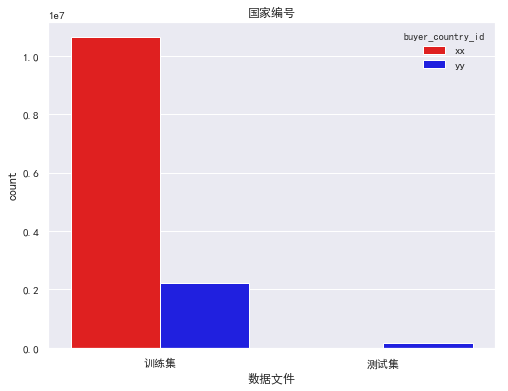

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='is_train', data = df, palette=['red', 'blue'], hue='buyer_country_id', order=[1, 0])
plt.xticks(np.arange(2), ('训练集', '测试集'))
plt.xlabel('数据文件')
plt.title('国家编号');

buyer_country_id 国家编号

> 本次比赛给出若干日内来自成熟国家的部分用户的行为数据，以及来自待成熟国家的A部分用户的行为数据，以及待成熟国家的B部分用户的行为数据去除每个用户的最后一条购买数据，让参赛人预测B部分用户的最后一条行为数据。

* 训练集中有2个国家数据，xx国家样本数10635642，占比83%，yy国家样本数2232867条，仅占17%
* 预测集中有yy国家的166832数据, 训练集中yy国样本数量是测试集中的13倍，如赛题目的所言，期望通过大量成熟国家来预测少量带成熟国家的用户购买行为

### buyer_admin_id 用户编号

In [ ]:
print('训练集中用户数量',len(df[train]['buyer_admin_id'].unique()))
print('测试集中用户数量',len(df[test]['buyer_admin_id'].unique()))

训练集中用户数量 809213
测试集中用户数量 11398


In [ ]:
union = list(set(df[train]['buyer_admin_id'].unique()).intersection(set(df[test]['buyer_admin_id'].unique())))
print('同时在训练集测试集出现的有6位用户，id如下：',union)

同时在训练集测试集出现的有6位用户，id如下： [12647969, 13000419, 3106927, 12858772, 12929117, 12368445]


In [ ]:
df[train][df['buyer_admin_id'].isin(union)].sort_values(by=['buyer_admin_id','irank']).head(10)

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
7546704,xx,3106927,7645546,2018-08-30 02:49:22,1,1,2018-08-30,30,2,1164.00,73781.00,770.00
4582539,xx,3106927,4639151,2018-08-30 02:49:22,2,1,2018-08-30,30,2,2214.00,53190.00,1669.00
11953258,xx,3106927,12122118,2018-08-30 02:49:22,3,1,2018-08-30,30,2,236.00,73781.00,884.00
255625,xx,3106927,258860,2018-08-30 02:49:22,4,1,2018-08-30,30,2,189.00,24221.00,900.00
7402817,xx,3106927,7499372,2018-08-30 02:49:22,5,1,2018-08-30,30,2,2214.00,32535.00,2714.00
9483312,xx,3106927,9613063,2018-08-30 02:49:22,6,1,2018-08-30,30,2,3069.00,73781.00,110.00
2740080,xx,3106927,2773189,2018-08-27 08:18:23,10,1,2018-08-27,27,8,1865.00,49499.00,20067.00
12152249,xx,3106927,12324030,2018-08-27 07:15:05,11,1,2018-08-27,27,7,880.00,92968.00,1764.00
2201292,xx,3106927,2227720,2018-08-19 02:36:36,12,1,2018-08-19,19,2,1164.00,6404.00,1900.00
6717641,xx,3106927,6804187,2018-08-19 02:33:39,13,1,2018-08-19,19,2,1164.00,52421.00,230.00


In [ ]:
df[test][df['buyer_admin_id'].isin(union)].sort_values(by=['buyer_admin_id','irank']).head(3)

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
13016145,yy,3106927,202354,2018-08-30 02:48:40,7,0,2018-08-30,30,2,642.00,24221.00,989.00
13008981,yy,3106927,6994414,2018-08-29 05:48:06,8,0,2018-08-29,29,5,7.00,37411.00,1521.00
13008982,yy,3106927,6994414,2018-08-29 05:48:06,9,0,2018-08-29,29,5,7.00,37411.00,1521.00


In [ ]:
df[(train) & (df['irank']==1) & (df['buyer_admin_id'].isin(['12858772','3106927','12368445']))]

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
3488248,xx,12858772,3530835,2018-08-27 20:49:33,1,1,2018-08-27,27,20,579.00,38151.00,399.00
6404074,xx,12368445,6486053,2018-08-31 04:24:46,1,1,2018-08-31,31,4,1423.00,55861.00,400.00
7546704,xx,3106927,7645546,2018-08-30 02:49:22,1,1,2018-08-30,30,2,1164.00,73781.00,770.00


emmm... 为啥同一个用户在训练集和测试集国家不一样了呢？但是其他信息能对上。。。，而且rank=1的结果直接给出来了。。。

id为12858772、3106927、12368445直接把结果给出来

可能是数据清洗出问题了，后面再看看怎么处理

#### 用户记录数分布

In [ ]:
admin_cnt = groupby_cnt_ratio(df, 'buyer_admin_id')
admin_cnt.groupby(['is_train','buyer_country_id']).head(3)

count  count_ratio
is_train buyer_country_id buyer_admin_id                    
1        xx               10828801        42751         0.00
                          10951390        23569         0.00
                          11223615        19933         0.00
         yy               2381782          3480         0.00
                          2333316          1944         0.00
                          2365356          1686         0.00
0        yy               2041038          1386         0.01
                          2070430           399         0.00
                          1144848           286         0.00

In [ ]:
# 用户购买记录数——最多、最少、中位数
admin_cnt.groupby(['is_train','buyer_country_id'])['count'].agg(['max','min','median'])

max  min  median
is_train buyer_country_id                    
0        yy                 1386    7      11
1        xx                42751    8      11
         yy                 3480    8      12

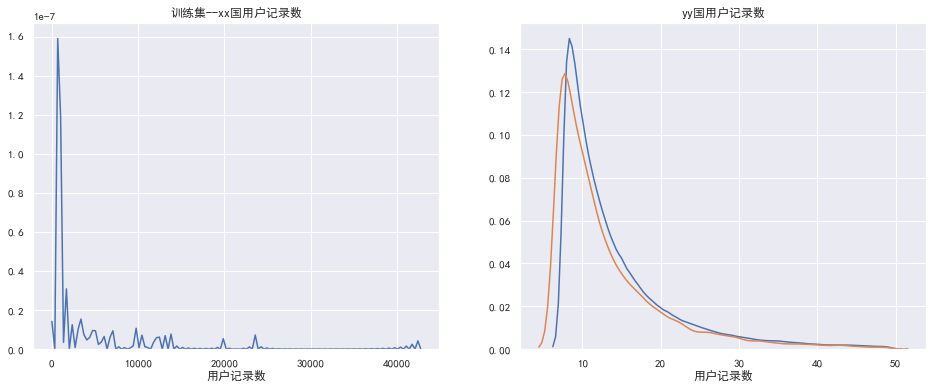

In [ ]:
fig, ax = plt.subplots(1, 2 ,figsize=(16,6))
ax[0].set(xlabel='用户记录数')
sns.kdeplot(admin_cnt.loc[(1, 'xx')]['count'].values, ax=ax[0]).set_title('训练集--xx国用户记录数')

ax[1].legend(labels=['训练集', '测试集'], loc="upper right")
ax[1].set(xlabel='用户记录数')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].loc[(1, 'yy')]['count'].values, ax=ax[1]).set_title('yy国用户记录数')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].loc[(0, 'yy')]['count'].values, ax=ax[1]);

用户记录数进行了一波简单的探查：
* 训练集中记录了*809213*个用户的数据，其中id为10828801的用户拔得头筹，有42751条购买记录，用户至少都有8条记录
* 训练集中记录了*11398*个用户的数据，其中id为2041038的用户勇冠三军，有1386条购买记录，用户至少有7条记录

Notes: 验证集中用户最少仅有7条，是因为最后一条记录被抹去

从上面数据和图表看到，用户记录数大都都分布在0~50，少量用户记录甚至超过了10000条，下一步对用户记录数分布继续探索

In [ ]:
admin_cnt.columns = ['记录数', '占比']
admin_user_cnt = groupby_cnt_ratio(admin_cnt, '记录数')
admin_user_cnt.columns = ['人数', '人数占比']
admin_user_cnt.head()

人数  人数占比
is_train buyer_country_id 记录数              
1        xx               8    118155  0.18
                          9     91757  0.14
                          10    72936  0.11
                          11    57678  0.09
                          12    46534  0.07

In [ ]:
# xx国——用户记录数与用户数
admin_user_cnt.loc[(1,'xx')][['人数','人数占比']].T

记录数,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,60,...,346,348,352,355,360,361,457,460,461,618,573,582,584,585,594,597,604,607,619,568,630,638,640,649,655,656,659,660,570,559,468,504,475,476,477,479,481,488,494,497,521,556,526,528,529,537,545,549,550,554
人数,118155.00,91757.00,72936.00,57678.00,46534.00,38114.00,31432.00,26735.00,22352.00,18742.00,16113.00,13677.00,12092.00,10097.00,8974.00,7749.00,6816.00,5910.00,5387.00,4751.00,4166.00,3769.00,3525.00,3005.00,2828.00,2476.00,2289.00,2069.00,1817.00,1683.00,1626.00,1464.00,1364.00,1218.00,1150.00,1001.00,988.00,963.00,802.00,768.00,710.00,681.00,597.00,595.00,548.00,533.00,503.00,473.00,448.00,428.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
人数占比,0.18,0.14,0.11,0.09,0.07,0.06,0.05,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# yy国——记录数与用户数占比
admin_user_cnt.loc[([1,0],'yy',slice(None))][['人数','人数占比']].unstack(0).drop('人数',1).head(10)

人数占比     
is_train                0    1
buyer_country_id 记录数          
yy               8   0.13 0.16
                 9   0.10 0.13
                 10  0.09 0.10
                 11  0.08 0.08
                 12  0.06 0.07
                 13  0.05 0.06
                 14  0.04 0.05
                 15  0.04 0.04
                 16  0.03 0.03
                 17  0.03 0.03

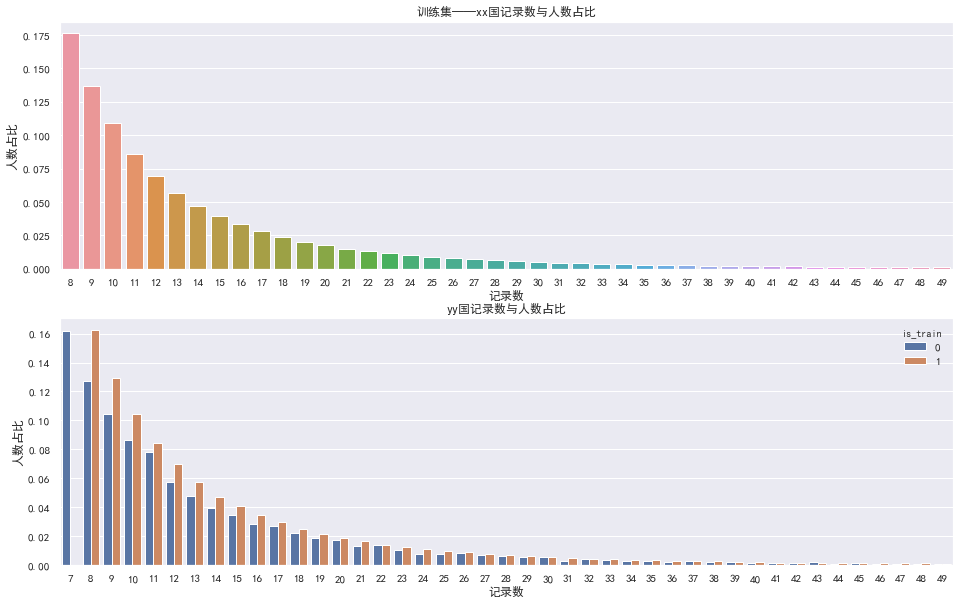

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))
admin_plot = admin_user_cnt.reset_index()
sns.barplot(x='记录数', y='人数占比', data=admin_plot[(admin_plot['记录数']<50) & (admin_plot['buyer_country_id']=='xx')], 
            estimator=np.mean, ax=ax[0]).set_title('训练集——xx国记录数与人数占比');

sns.barplot(x='记录数', y='人数占比', hue='is_train', data=admin_plot[(admin_plot['记录数']<50) & (admin_plot['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('yy国记录数与人数占比');

用户记录数进一步探查结论：
    * 不管是训练集还是验证集，99%的用户购买记录都在50条内，这是比较符合正常逻辑
    * TODO:对于发生大量购买行为的用户，后面再单独探查，是否有其他规律或疑似刷单现象

### item_id 商品编号

In [ ]:
print('商品表中商品数：',len(item['item_id'].unique()))
print('训练集中商品数：',len(df[train]['item_id'].unique()))
print('验证集中商品数：',len(df[test]['item_id'].unique()))
print('仅训练集有的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(df[test]['item_id'].unique())))))
print('仅验证集有的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(df[train]['item_id'].unique())))))
print('训练集验证集共同商品数：',len(list(set(df[train]['item_id'].unique()).intersection(set(df[test]['item_id'].unique())))))
print('训练集中不在商品表的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(item['item_id'].unique())))))
print('验证集中不在商品表的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(item['item_id'].unique())))))

商品表中商品数： 2832669
训练集中商品数： 2812048
验证集中商品数： 104735
仅训练集有的商品数： 2735801
仅验证集有的商品数： 28488
训练集验证集共同商品数： 76247
训练集中不在商品表的商品数： 7733
验证集中不在商品表的商品数： 313


#### 商品销量

In [ ]:
item_cnt = groupby_cnt_ratio(df, 'item_id')
item_cnt.columns=['销量', '总销量占比']
item_cnt.reset_index(inplace=True)

In [ ]:
top_item_plot = item_cnt.groupby(['is_train','buyer_country_id']).head(10)

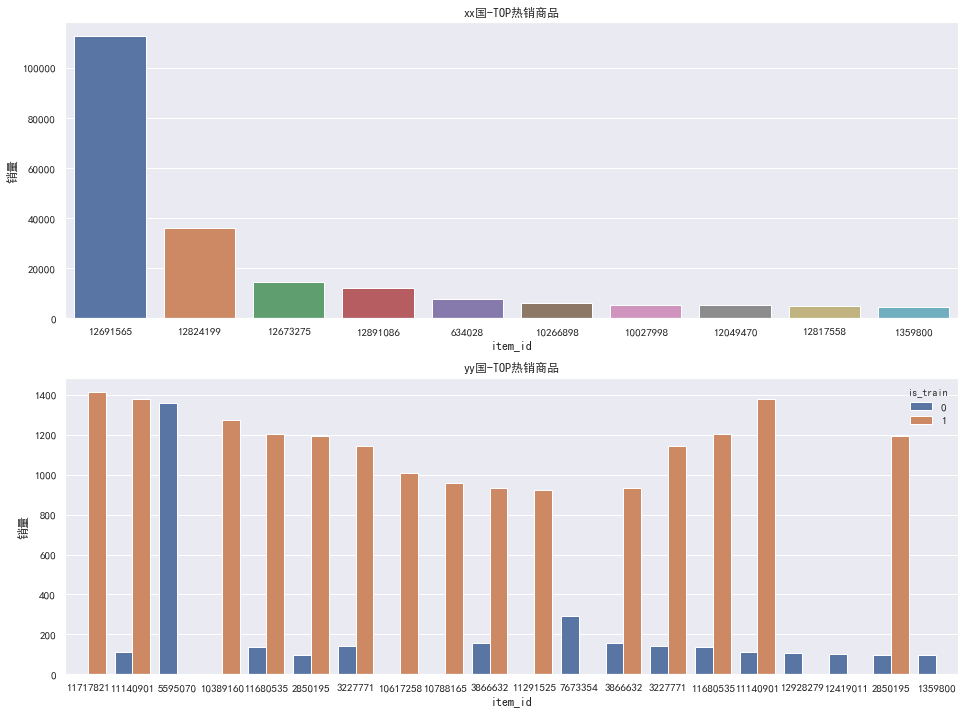

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16,12))
sns.barplot(x='item_id', y='销量', data=top_item_plot[top_item_plot['buyer_country_id']=='xx'], 
            order=top_item_plot['item_id'][top_item_plot['buyer_country_id']=='xx'], ax=ax[0], estimator=np.mean).set_title('xx国-TOP热销商品')
sns.barplot(x='item_id', y='销量', hue='is_train', data=top_item_plot[top_item_plot['buyer_country_id']=='yy'], 
            order=top_item_plot['item_id'][top_item_plot['buyer_country_id']=='yy'], ax=ax[1], estimator=np.mean).set_title('yy国-TOP热销商品');

初步数据发现：
* 训练集中出售最多商品是12691565，卖了112659次。
* 训练集中出售最多商品是5595070，卖了112659次。
* 大部分商品只有1次出售记录，符合电商长尾属性
* 比较奇怪的yy国中，训练集和测试集中热销商品并不太一样

#### 整体商品销量分布

In [ ]:
item_order_cnt = groupby_cnt_ratio(item_cnt, '销量')
item_order_cnt.columns = ['商品数', '占比']

In [ ]:
item_order_cnt.groupby(['is_train','buyer_country_id']).head(5).sort_values(by=['buyer_country_id','is_train'])

商品数   占比
is_train buyer_country_id 销量              
1        xx               1   1331056 0.58
                          2    361829 0.16
                          3    164953 0.07
                          4     95629 0.04
                          5     61551 0.03
0        yy               1     81212 0.78
                          2     13083 0.12
                          3      4350 0.04
                          4      2123 0.02
                          5      1200 0.01
1        yy               1    625041 0.67
                          2    139607 0.15
                          3     55274 0.06
                          4     29848 0.03
                          5     17782 0.02

In [ ]:
item_order_plot = item_order_cnt.reset_index()
item_order_plot = item_order_plot[item_order_plot['销量']<=8]

xx_item_order_plot = item_order_plot[item_order_plot['buyer_country_id']=='xx']
yy_item_order_plot = item_order_plot[item_order_plot['buyer_country_id']=='yy']
yy_item_order_plot_1 = yy_item_order_plot[yy_item_order_plot['is_train']==1]
yy_item_order_plot_0 = yy_item_order_plot[yy_item_order_plot['is_train']==0]

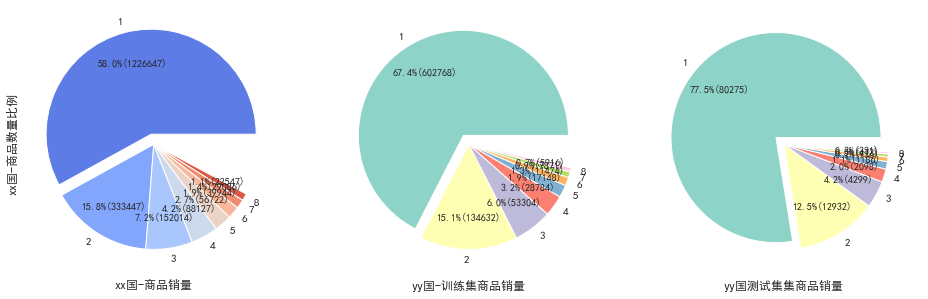

In [ ]:
# 商品销量饼图
def text_style_func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%({:d})".format(pct, absolute)

def pie_param(ax, df, color_palette):
    return ax.pie(df['占比'].values, autopct=lambda pct: text_style_func(pct, df['商品数']), labels = df['销量'], 
                  explode = [0.1]+ np.zeros(len(df)-1).tolist(), pctdistance = 0.7, colors=sns.color_palette(color_palette, 8))

fig, ax = plt.subplots(1, 3, figsize=(16,12))
ax[0].set(xlabel='xx国-商品销量')
ax[0].set(ylabel='xx国-商品数量比例')
pie_param(ax[0], xx_item_order_plot, "coolwarm")
ax[1].set(xlabel='yy国-训练集商品销量')
pie_param(ax[1], yy_item_order_plot_1, "Set3")
ax[2].set(xlabel='yy国测试集集商品销量')
pie_param(ax[2], yy_item_order_plot_0, "Set3");

In [ ]:
print(xx_item_order_plot.head(10)['占比'].sum())
print(yy_item_order_plot_1.head(10)['占比'].sum())
print(yy_item_order_plot_0.head(10)['占比'].sum())

0.9215598591503256
0.9643666018897873
0.9884661288012603


总体来看，由于训练集数据远多于测试集数据：
* 训练集商品销量大于测试集商品销量
* 长尾趋势严重，热门商品少，大量商品仅有数次销售记录，1单商品占了绝大部分(均超过50%)
* 训练集中92%的商品销量不超过10件，而在测试集中97%的商品销量不超过10件
* 此外训练集中yy国的商品销量略大于测试集

### cate_id 品类编号

In [ ]:
print('商品品类数', len(item['cate_id'].unique()))
print('训练集商品品类数', len(df[train]['cate_id'].unique()))
print('测试集商品品类数', len(df[test]['cate_id'].unique()))

商品品类数 4243
训练集商品品类数 4239
测试集商品品类数 2727


#### 各个品类下商品数量

In [ ]:
cate_cnt = item.groupby(['cate_id']).size().to_frame('count').reset_index()
cate_cnt.sort_values(by=['count'], ascending=False).head(5)

,cate_id,count
578,579,170074
2395,2396,44467
1497,1498,42676
599,600,39729
1591,1592,34820


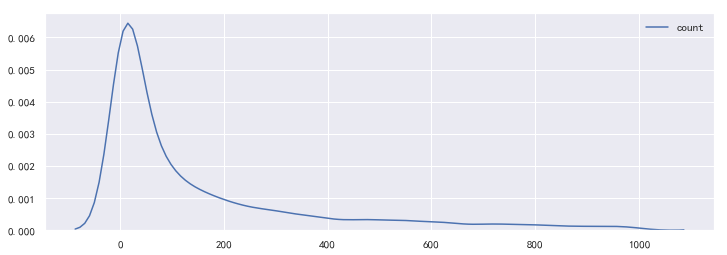

In [ ]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=cate_cnt[cate_cnt['count']<1000]['count']);

我们发现：
    * 579品类一花独秀有17W个商品，可能是平台主营方向
    * 大部分品类都在100个以上

### store_id 店铺编号

In [ ]:
print('商品店铺数', len(item['store_id'].unique()))
print('训练集店铺数', len(df[train]['store_id'].unique()))
print('测试集店铺数', len(df[train]['store_id'].unique()))

商品店铺数 95105
训练集店铺数 94970
测试集店铺数 94970


#### 店铺下品类数量

In [ ]:
store_cate_cnt = item.groupby(['store_id'])['cate_id'].nunique().to_frame('count').reset_index()
store_cate_cnt.sort_values(by=['count'], ascending=False).head(5)

,store_id,count
0,1,326
45594,45595,280
44983,44984,274
1870,1871,258
22034,22035,241


In [ ]:
store_cnt_cate_cnt = store_cate_cnt.groupby(['count']).size().reset_index()
store_cnt_cate_cnt.columns = ['店铺品类数', '店铺数量']

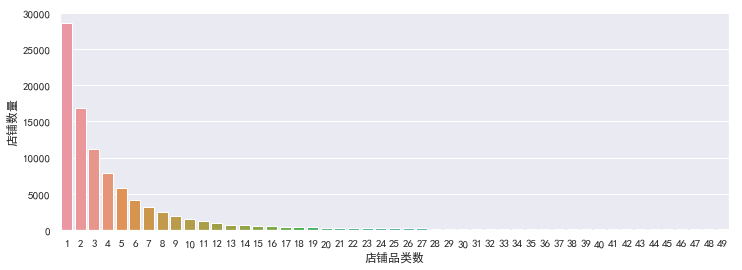

In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(x='店铺品类数', y='店铺数量', data=store_cnt_cate_cnt[store_cnt_cate_cnt['店铺品类数']<50], estimator=np.mean);

#### 店铺下商品数量

In [ ]:
store_item_cnt = item.groupby(['store_id'])['item_id'].nunique().to_frame('count').reset_index()
store_item_cnt.sort_values(by=['count'], ascending=False).head(5)

,store_id,count
0,1,6911
68671,68672,2435
33381,33382,2220
17544,17545,2053
82146,82147,2016


In [ ]:
store_cnt_item_cnt = store_item_cnt.groupby(['count']).size().reset_index()
store_cnt_item_cnt.columns = ['店铺商品数', '店铺数量']

In [ ]:
store_cnt_item_cnt.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628
店铺商品数,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,747,765,767,771,774,782,797,809,816,834,835,841,842,845,861,871,881,897,910,915,926,955,974,975,991,999,1019,1026,1051,1081,1083,1094,1138,1145,1161,1207,1276,1307,1374,1554,1556,1558,1642,1820,1997,2016,2053,2220,2435,6911
店铺数量,9129,6897,5593,4879,4206,3698,3374,3050,2773,2486,2251,2030,1966,1799,1673,1478,1437,1293,1246,1219,1171,1059,1044,958,910,885,772,792,709,675,656,626,596,582,538,532,479,456,496,437,441,415,401,383,374,371,330,325,335,306,...,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


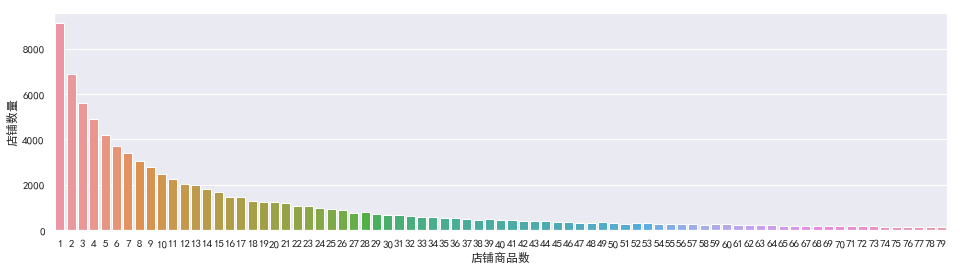

In [ ]:
plt.figure(figsize=(16,4))
sns.barplot(x='店铺商品数', y='店铺数量', data=store_cnt_item_cnt[store_cnt_item_cnt['店铺商品数']<80], estimator=np.mean);

#### item_price 商品价格

In [ ]:
print(item['item_price'].max(), item['item_price'].min(), item['item_price'].mean(), item['item_price'].median())

20230 1 1124.0030755446542 400.0


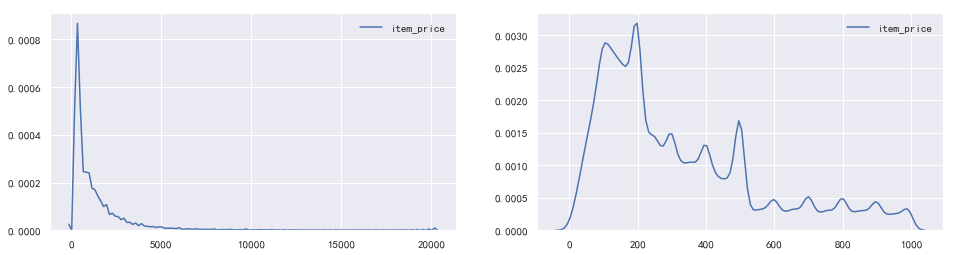

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sns.kdeplot(item['item_price'])
plt.subplot(122)
sns.kdeplot(item['item_price'][item['item_price']<1000]);

In [ ]:
price_cnt = item.groupby(['item_price']).size().to_frame('count').reset_index()
price_cnt.sort_values(by=['count'], ascending=False).head(10)

,item_price,count
199,200,75872
499,500,61283
99,100,33826
399,400,27670
299,300,26044
198,199,18032
999,1000,16739
699,700,12028
100,101,11972
120,121,11833


关于商品价格：商品价格是通过函数转化成了从1开始的整数，最大值为20230，最小值为1。
    * 经常对商品价格统计，大部门商品都是整百数，Top5价格200\500\100\400\300
    * TODO：整百商品探查

#### 有售商品价格

In [ ]:
print(df[train]['item_price'].max(), df[train]['item_price'].min(), df[train]['item_price'].mean(), df[train]['item_price'].median())
print(df[test]['item_price'].max(), df[test]['item_price'].min(), df[test]['item_price'].mean(), df[test]['item_price'].median())

20230.0 1.0 1103.9060915681803 245.0
19907.0 1.0 778.7395852140734 270.0


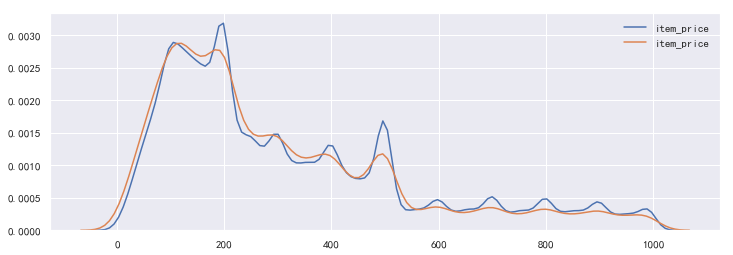

In [ ]:
plt.figure(figsize=(12,4))
sns.kdeplot(df[train][df[train]['item_price']<1000][['item_id','item_price']].drop_duplicates()['item_price'])
sns.kdeplot(df[test][df[test]['item_price']<1000][['item_id','item_price']].drop_duplicates()['item_price']);

商品价格与销量

In [ ]:
df[train].groupby(['item_price'])['item_id'].nunique().to_frame('商品数量').head()

,商品数量
item_price,
1.00,266
2.00,1305
3.00,204
4.00,152
5.00,133


In [ ]:
price_cnt = groupby_cnt_ratio(df, 'item_price')
price_cnt.groupby(['is_train', 'buyer_country_id']).head(5)

count  count_ratio
is_train buyer_country_id item_price                     
1        xx               200.00      404366         0.04
                          500.00      201061         0.02
                          100.00      186473         0.02
                          17844.00    114631         0.01
                          121.00       92956         0.01
         yy               200.00       82625         0.04
                          500.00       48651         0.02
                          100.00       38838         0.02
                          300.00       27452         0.01
                          400.00       24144         0.01
0        yy               200.00        6846         0.04
                          500.00        3582         0.02
                          100.00        3019         0.02
                          300.00        2084         0.01
                          400.00        1765         0.01

似乎价格与销量并无直接关系
    * 但是价格为100、200、300、400、500整百数位居销量榜
    * xx国，17844如此高价格的商品销量这么高？

### create_order_time 订单日期

In [ ]:
print(df[train]['create_order_time'].min(), df[train]['create_order_time'].max())
print(df[test]['create_order_time'].min(), df[test]['create_order_time'].max())

2018-07-13 05:54:54 2018-08-31 23:59:57
2018-07-17 07:43:40 2018-08-31 23:58:56


In [ ]:
train_df_seven = df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]
train_df_eight = df[train][df[train]['create_order_time']>pd.to_datetime('2018-08-01')]
train_df_seven = df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]
train_df_eight = df[train][df[train]['create_order_time']>pd.to_datetime('2018-08-01')]

In [ ]:
print('7月数据量',len(df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]),
      '\n8月数据量',len(df[train][df[train]['create_order_time']>pd.to_datetime('2018-08-02')]))

7月数据量 17856 
8月数据量 12838990


In [ ]:
date_cnt = groupby_cnt_ratio(df, 'date')
date_cnt.columns = ['当天销量', "占比"]
date_cnt = date_cnt.reset_index()

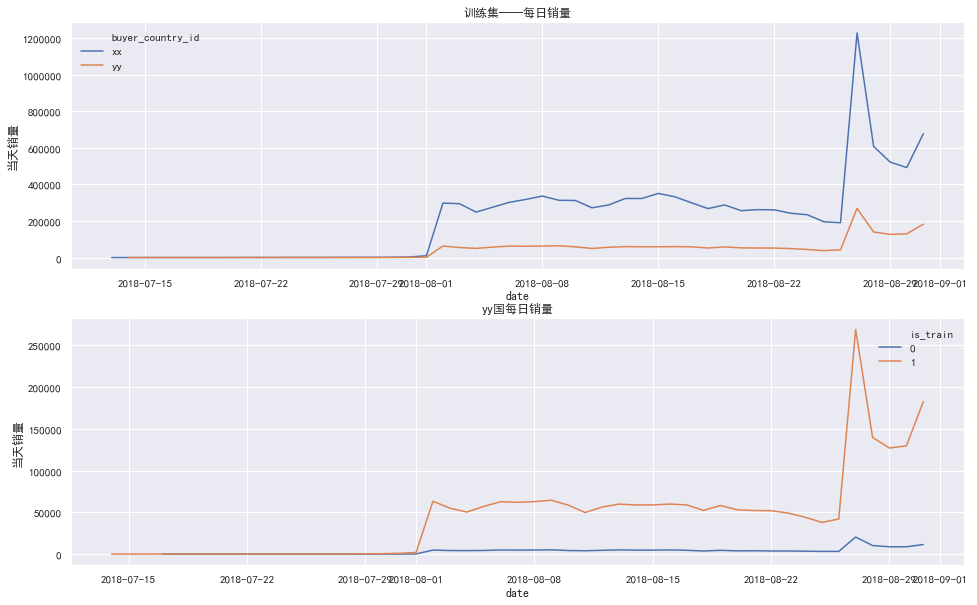

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))
sns.lineplot(x='date', y='当天销量', hue='buyer_country_id', data=date_cnt[(date_cnt['is_train']==1)], 
            estimator=np.mean, ax=ax[0]).set_title('训练集——每日销量');

sns.lineplot(x='date', y='当天销量', hue='is_train', data=date_cnt[(date_cnt['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('yy国每日销量');

很明显：
* 训练集中7月份数据远小于8月份数据
* 训练集中xx国和yy国每日销量趋势十分相似，且在27日有个波峰

In [ ]:
seven = date_cnt[date_cnt['date']<pd.to_datetime('2018-08-02')]
eight = date_cnt[date_cnt['date']>=pd.to_datetime('2018-08-02')]

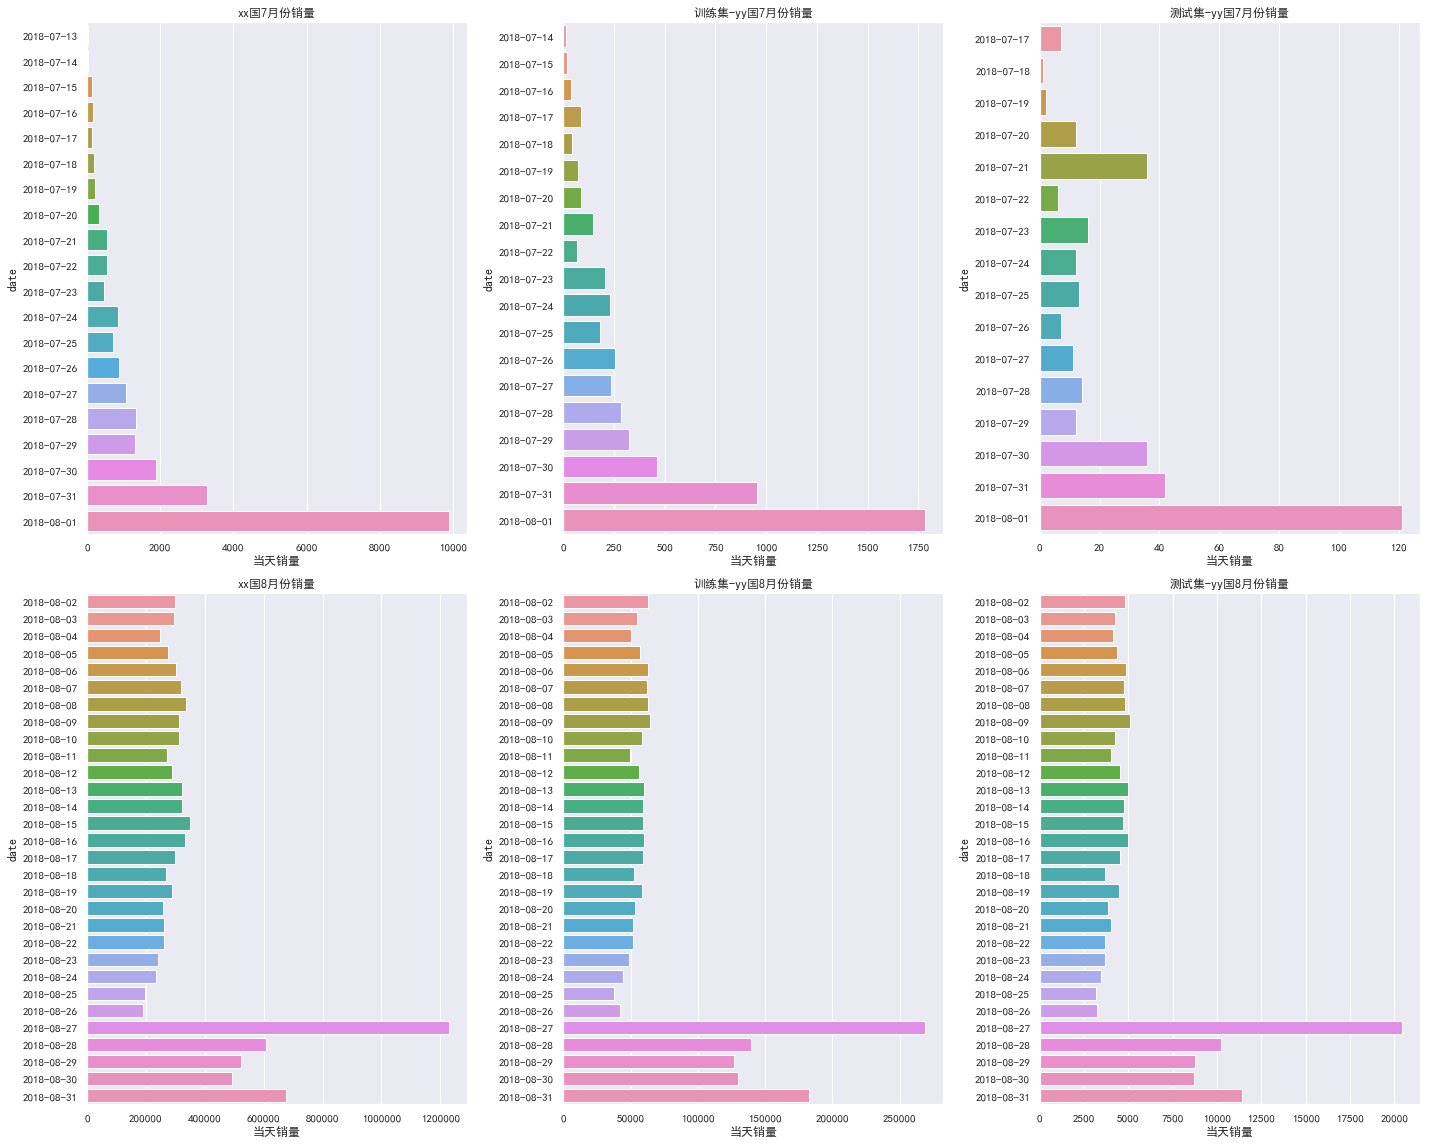

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20,16))
def barplot(ax, df, title):
    df['date'] = df['date'].astype(str)
    sns.barplot(y='date', x='当天销量' ,data=df, order=sorted(df['date'].unique()), ax=ax, estimator=np.mean)\
    .set_title(title)
    
barplot(ax[0][0], seven[(seven['is_train']==1) & (seven['buyer_country_id']=='xx')], 'xx国7月份销量')
barplot(ax[1][0], eight[(eight['is_train']==1) & (eight['buyer_country_id']=='xx')], 'xx国8月份销量')
barplot(ax[0][1], seven[(seven['is_train']==1) & (seven['buyer_country_id']=='yy')], '训练集-yy国7月份销量')
barplot(ax[1][1], eight[(eight['is_train']==1) & (eight['buyer_country_id']=='yy')], '训练集-yy国8月份销量')
barplot(ax[0][2], seven[(seven['is_train']==0) & (seven['buyer_country_id']=='yy')], '测试集-yy国7月份销量')
barplot(ax[1][2], eight[(eight['is_train']==0) & (eight['buyer_country_id']=='yy')], '测试集-yy国8月份销量')
plt.tight_layout()

数据放大后看：
* 训练集和测试集在8月份有相似的波动规律，27号出现波峰，当天剧增数据有待下一步探查

#### 每日uv与商品数(去重)

In [ ]:
unique = df.groupby(['is_train', 'buyer_country_id', 'date']).agg({'buyer_admin_id':'nunique','item_id':['nunique','size']})
unique.columns = ['uv','商品数(去重)', '销量']
unique = unique.reset_index()
unique = pd.melt(unique, id_vars=['is_train', 'buyer_country_id', 'date'], value_vars=['uv', '商品数(去重)', '销量'])
unique['date'] = unique['date'].astype(str)
unique = unique[unique['date']>='2018-08-02']

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(16,8), sharex=True)
sns.lineplot(x='date', y='value', hue='variable', data=unique[(unique['is_train']==1) & (unique['buyer_country_id']=='xx')], 
             estimator=np.mean, ax=ax[0]).set_title('xx国每日销售数据');

sns.lineplot(x='date', y='value', hue='variable', data=unique[(unique['is_train']==0) & (unique['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('训练集-yy国每日销量');

sns.lineplot(x='date', y='value', hue='variable', data=unique[(unique['is_train']==1) & (unique['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[2]).set_title('测试集-yy国每日销量')
plt.xticks(rotation=90);

对每日的uv、商品数和销量作图发现：
* 三者基本上呈正相关，xx国的商品单品销量更高

# BASELINE
选取用户近30次购买记录作为预测值，越近购买的商品放在越靠前的列，不够30次购买记录的用热销商品5595070填充

In [ ]:
test = pd.read_csv('../data/Antai_AE_round1_test_20190626.csv')
tmp = test[test['irank']<=31].sort_values(by=['buyer_country_id', 'buyer_admin_id', 'irank'])[['buyer_admin_id','item_id','irank']]
sub = tmp.set_index(['buyer_admin_id', 'irank']).unstack(-1)
sub.fillna(5595070).astype(int).reset_index().to_csv('../submit/sub.csv', index=False, header=None)

In [ ]:
# 最终提交文件格式
sub = pd.read_csv('../submit/sub.csv', header = None)
sub.head()

# 感谢阅读

本文代码已放于[github](https://github.com/RainFung/awesome-visualization/blob/master/Electronic-Commerce/%E8%B7%A8%E5%A2%83%E7%94%B5%E5%95%86%E6%99%BA%E8%83%BD%E7%AE%97%E6%B3%95%E5%A4%A7%E8%B5%9B-%E6%95%B0%E6%8D%AE%E6%8E%A2%E7%B4%A2%E4%B8%8E%E5%8F%AF%E8%A7%86%E5%8C%96.ipynb)

作者才疏学浅，文章中可能出现纰漏，忘读者多多指正交流，感谢支持